# vLife Virtusa

### Breast Cancer Proteomes Usecase
#### Usecase Description
##### Classification of tumor cells based on samples of protein expression data.Usecase build with XGB classifier uses Principal component Analysis for dimensionality reduction of proteins expression data.

### Data Source
Data for this usecase can be found [here](https://www.kaggle.com/piotrgrabo/breastcancerproteomes)
### Dataset Description
##### This data set contains published iTRAQ proteome profiling of 77 breast cancer samples generated by the Clinical Proteomic Tumor Analysis Consortium (NCI/NIH). It contains expression values for ~12.000 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.

* Content:

> File: 77cancerproteomesCPTACitraq.csv

 * RefSeqaccessionnumber: RefSeq protein ID (each protein has a unique
ID in a RefSeq database)
 * gene_symbol: a symbol unique to each gene (every protein is encoded
by some gene)
* gene_name: a full name of that gene
* Remaining columns: log2 iTRAQ ratios for each sample (protein expression data, most important), three last columns are from healthy individuals
> File: clinicaldatabreast_cancer.csv

First column "Complete TCGA ID" is used to match the sample IDs in the main cancer proteomes file (see example script).
All other columns have self-explanatory names, contain data about the cancer classification of a given sample using different methods. 'PAM50 mRNA' classification is being used in the example script.

>File: PAM50_proteins.csv

Contains the list of genes and proteins used by the PAM50 classification system. The column RefSeqProteinID contains the protein IDs that can be matched with the IDs in the main protein expression data set

### Import Packages

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hinge_loss
from sklearn.metrics import fbeta_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

In [2]:
clin_data_original=pd.read_csv('./data/clinical_data_breast_cancer.csv',index_col="Complete TCGA ID")

In [357]:
clin_data_original

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-A2-A0D0,FEMALE,60,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [362]:
prot_data=pd.read_csv('./data/77_cancer_proteomes_CPTAC_itraq.csv')
prot_data

,RefSeq_accession_number,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,...,-0.963904,-0.487772,-0.106680,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.106680,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,...,-0.943919,-0.487772,-0.106680,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,...,-0.935355,-0.487772,-0.106680,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,...,-0.935355,-0.503853,-0.106680,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747
5,NP_958780,PLEC,plectin isoform 1f,1.107561,2.646374,-0.654285,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.106680,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
6,NP_958783,PLEC,plectin isoform 1d,1.111370,2.650422,-0.648742,0.215413,-0.500619,2.783366,0.870186,...,-0.943919,-0.487772,-0.106680,-0.062523,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
7,NP_958784,NaN,plectin isoform 1b,1.111370,2.650422,-0.648742,0.215413,-0.500619,2.783366,0.870186,...,-0.943919,-0.487772,-0.106680,-0.062523,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
8,NP_112598,NaN,epiplakin,-1.517390,3.909313,-0.618256,-1.035760,-1.845366,2.205538,1.920171,...,-1.252252,-1.626289,0.025189,-2.187600,-1.969534,0.679466,-2.504862,-0.602132,-0.340726,-0.205013
9,NP_001611,AHNAK,neuroblast differentiation-associated protein ...,0.482754,-1.045294,1.222003,-0.517226,-0.405503,0.749997,2.349197,...,1.325752,0.731148,-1.177327,0.709931,1.307036,0.487574,0.694810,2.778263,1.367330,3.215190


### Exploratory Data Analysis
> <b> Data Preprocessing </b>

In [363]:
print ("Number of Samples in Clinical Data:", len(pd.DataFrame(clin_data_original['AJCC Stage'])))

freq_target_variable = pd.DataFrame(clin_data_original['AJCC Stage'].value_counts(ascending=True))
freq_target_variable.columns = ['Frequency']
freq_target_variable

Number of Samples in Clinical Data: 105


,Frequency
Stage IB,2
Stage IV,2
Stage III,3
Stage I,3
Stage IIIB,6
Stage IIIC,6
Stage IA,7
Stage II,11
Stage IIIA,12
Stage IIB,23


Text(0.5, 1.0, 'Frequency of AJCC Stages in Dataset')

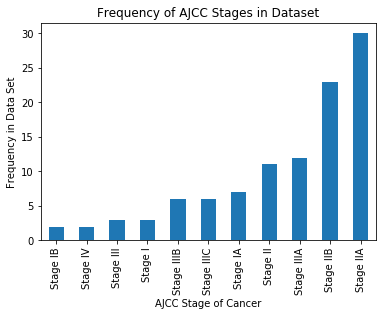

In [364]:
freq_stage_raw=clin_data_original['AJCC Stage'].value_counts(ascending=True)
freq_stage_raw=freq_stage_raw.plot(kind="bar")
freq_stage_raw.set_xlabel("AJCC Stage of Cancer")
freq_stage_raw.set_ylabel("Frequency in Data Set")
freq_stage_raw.set_title("Frequency of AJCC Stages in Dataset")

In [365]:
print("Number of samples in protein data:", len(prot_data.columns))
prot_data.describe().round(2)

Number of samples in protein data: 86


,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
count,11334.00,11335.00,11334.00,12024.00,12025.00,11833.00,11833.00,11732.00,11732.00,11276.00,...,11477.00,10324.00,10324.00,10324.00,9694.00,9693.00,9697.00,10912.00,10885.00,10913.00
mean,0.13,0.13,-0.44,-0.73,-0.04,0.12,-0.62,-0.31,-0.02,0.08,...,-0.68,-0.10,-0.02,-0.10,0.49,-0.37,-0.05,0.07,-0.30,0.31
std,1.73,1.58,1.63,2.42,1.35,1.65,2.28,1.57,1.65,1.75,...,2.02,1.57,1.66,1.63,1.66,1.45,1.72,1.95,1.31,1.71
min,-12.47,-13.16,-9.91,-24.55,-15.00,-12.96,-16.64,-18.71,-14.71,-13.44,...,-12.50,-12.15,-11.87,-11.13,-8.77,-10.43,-12.97,-12.61,-9.06,-6.33
25%,-0.66,-0.58,-1.33,-1.27,-0.67,-0.68,-1.28,-0.99,-0.72,-0.73,...,-1.73,-0.82,-0.74,-0.81,-0.50,-1.06,-0.93,-0.87,-1.06,-0.65
50%,0.08,0.12,-0.32,-0.30,0.02,0.09,-0.16,-0.23,0.04,0.05,...,-0.44,-0.06,0.02,-0.04,0.31,-0.20,-0.08,0.05,-0.19,0.14
75%,0.91,0.85,0.49,0.45,0.72,0.93,0.67,0.48,0.75,0.86,...,0.50,0.66,0.80,0.71,1.28,0.52,0.76,1.01,0.57,1.06
max,17.62,12.68,8.29,11.79,6.93,10.60,10.08,8.80,9.55,13.07,...,8.84,10.69,11.31,12.64,11.16,7.89,11.52,16.18,6.44,10.50


In [366]:
prot_data['gene_symbol'].fillna("NA",inplace = True)
prot_data['gene'] = prot_data['RefSeq_accession_number'] + " - " + prot_data['gene_name'].map(str) + " - " + \
                    prot_data['gene_symbol']

In [368]:
prot_data['gene']

0                     NP_958782 - plectin isoform 1 - PLEC
1                      NP_958785 - plectin isoform 1g - NA
2                    NP_958786 - plectin isoform 1a - PLEC
3                      NP_000436 - plectin isoform 1c - NA
4                      NP_958781 - plectin isoform 1e - NA
5                    NP_958780 - plectin isoform 1f - PLEC
6                    NP_958783 - plectin isoform 1d - PLEC
7                      NP_958784 - plectin isoform 1b - NA
8                               NP_112598 - epiplakin - NA
9        NP_001611 - neuroblast differentiation-associa...
10       NP_076965 - neuroblast differentiation-associa...
11       NP_001367 - cytoplasmic dynein 1 heavy chain 1...
12       NP_036222 - microtubule-actin cross-linking fa...
13       NP_001138241 - bullous pemphigoid antigen 1 is...
14       NP_001714 - bullous pemphigoid antigen 1 isofo...
15                             NP_002464 - myosin-9 - MYH9
16         NP_001073936 - unconventional myosin-Vb - MYO

In [9]:
prot_data = prot_data.set_index('gene')
prot_data = prot_data.drop(['gene_name','gene_symbol','RefSeq_accession_number'],1)

In [10]:
prot_data_reduced = prot_data.dropna(axis = 0)
prot_data_reduced = prot_data_reduced.transpose()

In [12]:
prot_data_reduced

gene,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_001652 - ADP-ribosylation factor-like protein 4D - ARL4D,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2"
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,0.235117,-2.043143,-1.578347,6.780350,-1.010687,2.654339,-0.119194,-2.024094,1.637123,-0.252537
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,-0.442159,2.468267,1.039365,1.176993,-0.049515,0.715535,1.144610,-0.166903,1.059605,2.193011
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,1.950900,-4.301545,-2.586002,2.147675,-2.577688,0.160528,-1.203037,-3.071010,1.648810,-2.813263
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.707184,2.008538,2.149044,3.811698,-0.329884,-8.716757,1.700762,2.353112,0.422827,0.389373
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.664094,1.181953,1.201633,-1.182832,2.480781,0.388225,0.371826,-1.445222,0.493181,2.369266
TCGA-C8-A138,2.765081,2.779709,2.779709,2.797995,2.787023,2.779709,2.783366,2.783366,2.205538,0.749997,...,-3.426456,-1.733201,-0.584859,-1.184630,2.110453,1.496053,-1.718572,0.197769,-2.354914,-0.354459
TCGA-E2-A154,0.862659,0.870186,0.870186,0.866423,0.870186,0.870186,0.870186,0.870186,1.920171,2.349197,...,1.641680,-0.409365,-1.737840,-1.116882,-1.135699,-3.694801,0.873949,4.618518,0.636856,-0.488396
TCGA-C8-A12L,1.407570,1.407570,1.410312,1.407570,1.413053,1.407570,1.410312,1.413053,3.195070,-0.007077,...,1.377413,0.217731,1.711884,-1.399792,2.095703,-0.870670,-0.851479,1.914760,0.763303,0.415124
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,2.130577,2.378200,2.509515,0.948741,0.108324,-0.743348,0.787411,3.158587,2.948483,2.025525


In [11]:
prot_data_reduced.index = pd.Series([val[10:14] + "-" + val[0:7]
                                     for val in prot_data_reduced.index], index = prot_data_reduced.index)
prot_data_reduced.index.rename("Complete TCGA ID",inplace = True)

In [20]:
prot_data_reduced = prot_data_reduced.sort_index()

In [22]:
prot_data_reduced

gene,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_001652 - ADP-ribosylation factor-like protein 4D - ARL4D,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2"
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
PTAC-263d3f-,0.598585,0.606697,0.603993,0.603993,0.603993,0.606697,0.603993,0.603993,-0.602132,2.778263,...,0.906877,2.924296,-0.028817,0.301110,-0.469620,0.641854,0.420100,0.847382,-1.099726,-0.453395
PTAC-blcdb9-,-0.191285,-0.183918,-0.186022,-0.186022,-0.167079,-0.183918,-0.186022,-0.186022,-0.340726,1.367330,...,-0.086044,-0.850091,-1.132136,0.739043,-3.190644,-2.257159,0.226521,0.520142,-0.592251,-4.235684
PTAC-c4155b-,0.566975,0.578702,0.576747,0.576747,0.576747,0.578702,0.576747,0.576747,-0.205013,3.215190,...,-0.011528,4.010631,-0.818696,0.738963,-1.158762,-0.720976,-0.537262,0.948084,-0.595894,-2.452576
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,0.617280,-1.502339,2.130769,1.098511,-0.819065,-0.675798,0.014823,1.550354,-0.216608,1.032388
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,2.136604,2.322883,1.225166,1.777351,1.062172,-2.759878,0.154061,0.237221,0.270485,0.456764
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,2.133697,1.643829,1.364451,2.481962,1.785431,-1.203529,0.664093,0.289037,-0.047747,0.128299
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,1.335175,1.884093,2.231367,2.463817,-3.078572,-6.167635,0.842269,4.158181,-0.160346,-2.325210
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,2.130577,2.378200,2.509515,0.948741,0.108324,-0.743348,0.787411,3.158587,2.948483,2.025525
TCGA-A2-A0EY,1.174881,1.183209,1.183209,1.174881,1.179045,1.183209,1.183209,1.183209,4.955702,0.825113,...,3.335945,3.365092,4.339444,1.328945,3.864760,0.512821,0.691869,-0.365762,2.153397,1.878580


In [21]:
prot_data_reduced.index.value_counts().head()

TCGA-AO-A12D    2
TCGA-C8-A131    2
TCGA-AO-A12B    2
TCGA-AN-A0AJ    1
TCGA-AO-A0JE    1
Name: Complete TCGA ID, dtype: int64

In [32]:
for i in range(1,len(prot_data_reduced)):
    if prot_data_reduced.index[i] == prot_data_reduced.index[i-1]: 
        print('hi')
        prot_range = prot_data_reduced.index.values
        prot_range[i] = prot_data_reduced.index[i] + "B"
        drop = prot_data_reduced.index[i] + "B"
        prot_data_reduced.set_index(prot_range)
        prot_data_reduced.drop(drop,0)

In [33]:
prot_data_reduced.index.value_counts().head()

TCGA-AN-A0AJ    1
TCGA-A2-A0EY    1
TCGA-AO-A0JM    1
TCGA-A2-A0EX    1
TCGA-AO-A12B    1
Name: Complete TCGA ID, dtype: int64

In [34]:
clin_data_original.describe().round(2)

,Age at Initial Pathologic Diagnosis,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
count,105.00,105.00,11.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00,105.00
mean,58.69,788.39,1254.45,0.10,817.65,-4.89,-7.18,4.00,3.34,2.59,2.74,1.98,2.35
std,13.07,645.28,678.05,0.31,672.03,3.56,5.02,1.59,1.41,1.34,1.07,0.97,1.09
min,30.00,0.00,160.00,0.00,0.00,-12.00,-13.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,49.00,240.00,947.50,0.00,240.00,-6.00,-12.00,3.00,2.00,1.00,2.00,1.00,1.00
50%,58.00,643.00,1364.00,0.00,665.00,-5.00,-6.00,4.00,4.00,3.00,3.00,2.00,2.00
75%,67.00,1288.00,1627.50,0.00,1305.00,-3.00,-2.00,5.00,4.00,3.00,4.00,3.00,3.00
max,88.00,2850.00,2483.00,1.00,2850.00,0.00,0.00,7.00,5.00,5.00,4.00,4.00,5.00


In [35]:
clin_data_original = clin_data_original.dropna(axis = 1)

In [36]:
combined_table = clin_data_original.join(prot_data_reduced)

In [37]:
combined_table = combined_table.dropna(axis = 0)

In [38]:
combined_table

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,NP_001652 - ADP-ribosylation factor-like protein 4D - ARL4D,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2"
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,0.617280,-1.502339,2.130769,1.098511,-0.819065,-0.675798,0.014823,1.550354,-0.216608,1.032388
TCGA-A2-A0D2,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,2.136604,2.322883,1.225166,1.777351,1.062172,-2.759878,0.154061,0.237221,0.270485,0.456764
TCGA-A2-A0EQ,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,M0,...,2.133697,1.643829,1.364451,2.481962,1.785431,-1.203529,0.664093,0.289037,-0.047747,0.128299
TCGA-A2-A0EV,FEMALE,80,Positive,Positive,Negative,T1,T1,N0,Negative,M0,...,1.335175,1.884093,2.231367,2.463817,-3.078572,-6.167635,0.842269,4.158181,-0.160346,-2.325210
TCGA-A2-A0EX,FEMALE,46,Positive,Positive,Negative,T3,T_Other,N0,Negative,M0,...,2.130577,2.378200,2.509515,0.948741,0.108324,-0.743348,0.787411,3.158587,2.948483,2.025525
TCGA-A2-A0EY,FEMALE,62,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,...,3.335945,3.365092,4.339444,1.328945,3.864760,0.512821,0.691869,-0.365762,2.153397,1.878580
TCGA-A2-A0SW,FEMALE,82,Positive,Negative,Negative,T2,T_Other,N2,Positive,M1,...,0.975576,-1.028086,1.538402,1.612373,0.126512,-4.105941,0.821200,1.203922,-1.352917,0.332346
TCGA-A2-A0SX,FEMALE,48,Negative,Negative,Negative,T1,T1,N0,Negative,M0,...,-0.273433,-1.631953,0.536912,4.978915,4.323489,-4.792895,-0.294287,0.724603,-1.745163,1.222131
TCGA-A2-A0T3,FEMALE,37,Positive,Positive,Negative,T1,T1,N1,Positive,M0,...,0.676417,0.512640,0.299422,0.342684,2.277100,-4.604600,1.912465,2.545940,1.927916,1.513840


In [39]:
target_column = ['AJCC Stage']
subtarget_columns = ['Metastasis','Tumor','Node']
other_clusterings = ['miRNA Clusters']

Text(0.5, 1.0, 'Frequencies Of AJCC Stage In Dataset')

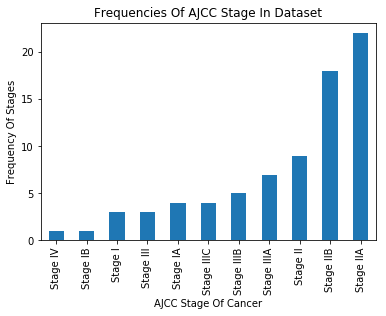

In [40]:
freq_stage_processed = combined_table['AJCC Stage'].value_counts(ascending=True)

freq_stage_processed = freq_stage_processed.plot(kind='bar')
freq_stage_processed.set_xlabel('AJCC Stage Of Cancer')
freq_stage_processed.set_ylabel('Frequency Of Stages')
freq_stage_processed.set_title('Frequencies Of AJCC Stage In Dataset')

In [41]:
combined_table['AJCC Stage Classes'] = pd.Series([val.replace("B","").replace("A","").replace("C","") 
                                                  for val in combined_table['AJCC Stage']], 
                                                  index = combined_table.index)

In [42]:
freq_target_variable['Frequency Without Subdivisions'] = combined_table['AJCC Stage Classes'].value_counts()
freq_target_variable.fillna("-",inplace=True)
freq_target_variable.sort_index()

,Frequency,Frequency Without Subdivisions
Stage I,3,8
Stage IA,7,-
Stage IB,2,-
Stage II,11,49
Stage IIA,30,-
Stage IIB,23,-
Stage III,3,19
Stage IIIA,12,-
Stage IIIB,6,-
Stage IIIC,6,-


Text(0.5, 1.0, 'Frequencies Of Reduced AJCC Stages In Dataset')

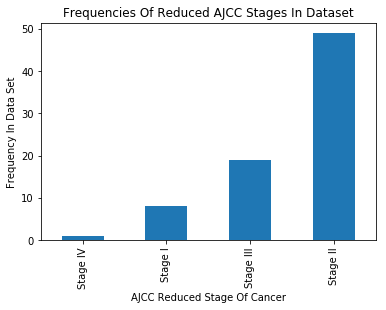

In [43]:
freq_reduced_stage_processed = combined_table['AJCC Stage Classes'].value_counts(ascending=True)

freq_reduced_stage_processed = freq_reduced_stage_processed.plot(kind='bar')
freq_reduced_stage_processed.set_xlabel("AJCC Reduced Stage Of Cancer")
freq_reduced_stage_processed.set_ylabel("Frequency In Data Set")
freq_reduced_stage_processed.set_title("Frequencies Of Reduced AJCC Stages In Dataset")

In [45]:
print (combined_table['AJCC Stage'][combined_table['AJCC Stage'] == "Stage IV"])
print (combined_table['AJCC Stage'][combined_table['AJCC Stage'] == "Stage IB"])

Complete TCGA ID
TCGA-A2-A0SW    Stage IV
Name: AJCC Stage, dtype: object
Complete TCGA ID
TCGA-C8-A12U    Stage IB
Name: AJCC Stage, dtype: object


In [46]:
combined_table.drop("TCGA-A2-A0SW", axis = 0, inplace = True)
combined_table.drop("TCGA-C8-A12U", axis = 0, inplace = True)

Frequency Of Target Classes
Stage I       7
Stage III    19
Stage II     49
Name: AJCC Stage Classes, dtype: int64


Text(0.5, 1.0, 'Frequencies Of Reduced AJCC Stages In Dataset Without Smallest Subclasses')

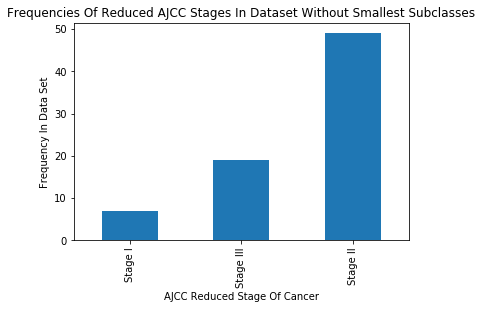

In [48]:
print ("Frequency Of Target Classes")
print (combined_table['AJCC Stage Classes'].value_counts(ascending=True))

freq_reduced_stage_processed_cut = combined_table['AJCC Stage Classes'].value_counts(ascending=True)

freq_reduced_stage_processed_cut = freq_reduced_stage_processed_cut.plot(kind='bar')
freq_reduced_stage_processed_cut.set_xlabel("AJCC Reduced Stage Of Cancer")
freq_reduced_stage_processed_cut.set_ylabel("Frequency In Data Set")
freq_reduced_stage_processed_cut.set_title("Frequencies Of Reduced AJCC Stages In Dataset Without Smallest Subclasses")

In [49]:
combined_table

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2",AJCC Stage Classes
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,-1.502339,2.130769,1.098511,-0.819065,-0.675798,0.014823,1.550354,-0.216608,1.032388,Stage II
TCGA-A2-A0D2,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,2.322883,1.225166,1.777351,1.062172,-2.759878,0.154061,0.237221,0.270485,0.456764,Stage II
TCGA-A2-A0EQ,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,M0,...,1.643829,1.364451,2.481962,1.785431,-1.203529,0.664093,0.289037,-0.047747,0.128299,Stage II
TCGA-A2-A0EV,FEMALE,80,Positive,Positive,Negative,T1,T1,N0,Negative,M0,...,1.884093,2.231367,2.463817,-3.078572,-6.167635,0.842269,4.158181,-0.160346,-2.325210,Stage I
TCGA-A2-A0EX,FEMALE,46,Positive,Positive,Negative,T3,T_Other,N0,Negative,M0,...,2.378200,2.509515,0.948741,0.108324,-0.743348,0.787411,3.158587,2.948483,2.025525,Stage II
TCGA-A2-A0EY,FEMALE,62,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,...,3.365092,4.339444,1.328945,3.864760,0.512821,0.691869,-0.365762,2.153397,1.878580,Stage II
TCGA-A2-A0SX,FEMALE,48,Negative,Negative,Negative,T1,T1,N0,Negative,M0,...,-1.631953,0.536912,4.978915,4.323489,-4.792895,-0.294287,0.724603,-1.745163,1.222131,Stage I
TCGA-A2-A0T3,FEMALE,37,Positive,Positive,Negative,T1,T1,N1,Positive,M0,...,0.512640,0.299422,0.342684,2.277100,-4.604600,1.912465,2.545940,1.927916,1.513840,Stage I
TCGA-A2-A0T6,FEMALE,50,Positive,Positive,Negative,T3,T_Other,N0,Negative,M0,...,2.806528,2.761574,-0.585764,-0.278002,-5.008537,0.233781,2.571384,0.462008,1.959319,Stage II


## Predictive Models
> <b> Building Baseline Model </b>

In [79]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

combined_table.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in combined_table.columns.values]

In [80]:
lbl_enc = LabelEncoder().fit(combined_table['AJCC Stage Classes'])
combined_table['AJCC Stage Classes'] = lbl_enc.transform(combined_table['AJCC Stage Classes'])

Text(0.5, 1.0, 'Frequencies Of Encoded Reduced AJCC Stages In Dataset')

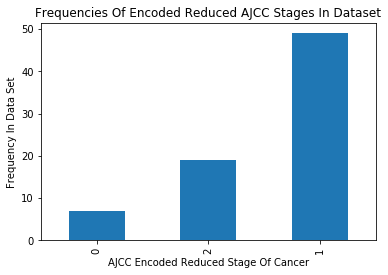

In [81]:
freq_reduced_stage_encoded = combined_table['AJCC Stage Classes'].value_counts(ascending=True)

freq_reduced_stage_encoded = freq_reduced_stage_encoded.plot(kind='bar')
freq_reduced_stage_encoded.set_xlabel("AJCC Encoded Reduced Stage Of Cancer")
freq_reduced_stage_encoded.set_ylabel("Frequency In Data Set")
freq_reduced_stage_encoded.set_title("Frequencies Of Encoded Reduced AJCC Stages In Dataset")

In [82]:
protein_columns = [val for val in combined_table.columns if "NP_" in val or "XP_" in val or "YP_" in val]
combined_table_proteins = combined_table[protein_columns]

In [83]:
def split_data(data,target,eval_size):
    kf = StratifiedShuffleSplit(n_splits = 1, test_size = eval_size, random_state = 0)
    for train_indice, valid_indice in kf.split(data,target):
        X_train, X_valid = data.iloc[train_indice], data.iloc[valid_indice]
        y_train, y_valid = target.iloc[train_indice],target.iloc[valid_indice]
    return X_train, y_train, X_valid, y_valid

In [84]:
def dummy_clf(val,score):
    X_train_prot, y_train_prot, X_valid_prot, y_valid_prot = split_data(combined_table_proteins,
                                                                        combined_table[val],0.35)
    dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_prot,y_train_prot)
    score = score(y_valid_prot,dummy_clf.predict(X_valid_prot),average = 'weighted').round(2)
    return score

In [86]:
exploriative = pd.DataFrame(index = target_column + subtarget_columns + other_clusterings + ['AJCC Stage Classes'])
exploriative['Unique Values'] = [len(combined_table[val].unique()) for val in exploriative.index]
exploriative['Mode'] = [combined_table[val].mode().iloc[0] for val in exploriative.index]
exploriative['Dummy Score'] = [dummy_clf(val,f1_score) for val in exploriative.index]
print (exploriative)

                    Unique Values       Mode  Dummy Score
AJCC Stage                      9  Stage IIA         0.14
Metastasis                      1         M0         1.00
Tumor                           4         T2         0.53
Node                            4         N0         0.35
miRNA Clusters                  7          4         0.20
AJCC Stage Classes              3          1         0.53


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

In [87]:
X_train_prot, y_train_prot, X_valid_prot, y_valid_prot = split_data(combined_table_proteins,
                                                                    combined_table['AJCC Stage Classes'],0.35)

In [88]:
X_train_prot

,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_001652 - ADP-ribosylation factor-like protein 4D - ARL4D,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2"
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AR-A0TV,-1.514278,-1.528285,-1.528285,-1.531087,-1.514278,-1.525484,-1.525484,-1.525484,-3.147506,-1.738392,...,-1.391016,-0.488959,-4.733109,0.471928,-1.491867,0.160970,-0.693463,-1.984917,0.132956,-2.088569
TCGA-AR-A0TT,-0.511421,-0.526067,-0.526067,-0.533389,-0.529728,-0.529728,-0.529728,-0.529728,-4.952666,-0.526067,...,0.228176,3.204871,1.798905,4.200765,0.612620,-1.064288,1.161826,3.790691,1.117889,0.989741
TCGA-BH-A0C1,-0.518366,-0.510002,-0.507214,-0.518366,-0.512790,-0.507214,-0.510002,-0.510002,-2.439413,-2.174537,...,1.093194,-0.454239,1.182415,4.570037,1.346917,-1.059271,1.029066,1.146169,1.954737,-0.925439
TCGA-AR-A1AV,-0.759823,-0.759823,-0.749114,-0.735727,-0.749114,-0.743759,-0.754468,-0.754468,-0.700922,0.726102,...,-3.075724,-4.617872,-4.251076,0.771616,1.320471,0.195988,-0.754468,-2.864214,-3.637965,-2.484031
TCGA-A8-A079,1.048959,1.052257,1.052257,1.058852,1.052257,1.052257,1.052257,1.052257,0.679618,3.436487,...,3.189160,1.111615,0.778549,-1.833222,-0.329475,0.966517,0.300384,1.444682,2.565897,1.810726
TCGA-AR-A0TX,-0.583429,-0.572549,-0.567109,-0.583429,-0.572549,-0.577989,-0.577989,-0.577989,0.730304,1.638765,...,0.610626,-0.373993,0.267913,2.462907,-3.866400,-5.884597,-0.689506,2.737621,-1.540848,-2.683224
TCGA-A2-A0T3,0.583713,0.580623,0.580623,0.586803,0.586803,0.586803,0.586803,0.586803,0.052212,1.501479,...,0.676417,0.512640,0.299422,0.342684,2.277100,-4.604600,1.912465,2.545940,1.927916,1.513840
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.707184,2.008538,2.149044,3.811698,-0.329884,-8.716757,1.700762,2.353112,0.422827,0.389373
TCGA-C8-A12T,-0.204918,-0.162418,-0.166668,-0.183668,-0.166668,-0.166668,-0.166668,-0.166668,2.425796,0.470823,...,-1.628649,1.312311,1.006316,-0.425915,-4.310362,-0.362166,-0.175168,0.564322,0.054329,0.130828


Text(0.5, 1.0, 'Frequencies Of Encoded Reduced AJCC Stages In Dataset')

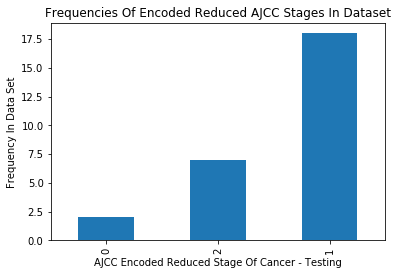

In [89]:
freq_reduced_stage_testing_encoded = y_valid_prot.value_counts(ascending=True)

freq_reduced_stage_testing_encoded = freq_reduced_stage_testing_encoded.plot(kind='bar')
freq_reduced_stage_testing_encoded.set_xlabel("AJCC Encoded Reduced Stage Of Cancer - Testing")
freq_reduced_stage_testing_encoded.set_ylabel("Frequency In Data Set")
freq_reduced_stage_testing_encoded.set_title("Frequencies Of Encoded Reduced AJCC Stages In Dataset")

### Model Selection

In [90]:
rfc = RandomForestClassifier(random_state = 0)
xgb = XGBClassifier(seed = 0)
lgr = LogisticRegression(random_state = 0)
kmm = KMeans(random_state = 0)
svm = SVC(random_state = 0, probability = True)
gnb = GaussianNB()

In [152]:
X_train_prot

,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_001652 - ADP-ribosylation factor-like protein 4D - ARL4D,NP_071753 - potassium channel subfamily K member 15 precursor - NA,"NP_001294 - protoheme IX farnesyltransferase, mitochondrial - COX10",NP_065775 - RING finger protein 150 precursor - RNF150,NP_001094348 - maestro heat-like repeat-containing protein family member 6 - C8ORF73,XP_003846524 - PREDICTED: ADP-ribosylation factor-like protein 17-like - NA,NP_443073 - testis-specific serine/threonine-protein kinase 3 - TSSK3,NP_001004456 - olfactory receptor 1M1 - OR1M1,NP_997625 - ADP-ribosylation factor-like protein 4A - ARL4A,"NP_003270 - troponin C, skeletal muscle - TNNC2"
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AR-A0TV,-1.514278,-1.528285,-1.528285,-1.531087,-1.514278,-1.525484,-1.525484,-1.525484,-3.147506,-1.738392,...,-1.391016,-0.488959,-4.733109,0.471928,-1.491867,0.160970,-0.693463,-1.984917,0.132956,-2.088569
TCGA-AR-A0TT,-0.511421,-0.526067,-0.526067,-0.533389,-0.529728,-0.529728,-0.529728,-0.529728,-4.952666,-0.526067,...,0.228176,3.204871,1.798905,4.200765,0.612620,-1.064288,1.161826,3.790691,1.117889,0.989741
TCGA-BH-A0C1,-0.518366,-0.510002,-0.507214,-0.518366,-0.512790,-0.507214,-0.510002,-0.510002,-2.439413,-2.174537,...,1.093194,-0.454239,1.182415,4.570037,1.346917,-1.059271,1.029066,1.146169,1.954737,-0.925439
TCGA-AR-A1AV,-0.759823,-0.759823,-0.749114,-0.735727,-0.749114,-0.743759,-0.754468,-0.754468,-0.700922,0.726102,...,-3.075724,-4.617872,-4.251076,0.771616,1.320471,0.195988,-0.754468,-2.864214,-3.637965,-2.484031
TCGA-A8-A079,1.048959,1.052257,1.052257,1.058852,1.052257,1.052257,1.052257,1.052257,0.679618,3.436487,...,3.189160,1.111615,0.778549,-1.833222,-0.329475,0.966517,0.300384,1.444682,2.565897,1.810726
TCGA-AR-A0TX,-0.583429,-0.572549,-0.567109,-0.583429,-0.572549,-0.577989,-0.577989,-0.577989,0.730304,1.638765,...,0.610626,-0.373993,0.267913,2.462907,-3.866400,-5.884597,-0.689506,2.737621,-1.540848,-2.683224
TCGA-A2-A0T3,0.583713,0.580623,0.580623,0.586803,0.586803,0.586803,0.586803,0.586803,0.052212,1.501479,...,0.676417,0.512640,0.299422,0.342684,2.277100,-4.604600,1.912465,2.545940,1.927916,1.513840
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.707184,2.008538,2.149044,3.811698,-0.329884,-8.716757,1.700762,2.353112,0.422827,0.389373
TCGA-C8-A12T,-0.204918,-0.162418,-0.166668,-0.183668,-0.166668,-0.166668,-0.166668,-0.166668,2.425796,0.470823,...,-1.628649,1.312311,1.006316,-0.425915,-4.310362,-0.362166,-0.175168,0.564322,0.054329,0.130828


In [91]:
rfc_trained = rfc.fit(X_train_prot,y_train_prot)
xgb_trained = xgb.fit(X_train_prot,y_train_prot)
lgr_trained = lgr.fit(X_train_prot,y_train_prot)
kmm_trained = kmm.fit(X_train_prot,y_train_prot)
gnb_trained = GaussianNB().fit(X_train_prot,y_train_prot)
svm_trained = svm.fit(X_train_prot,y_train_prot)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'aut

In [92]:
models = ['Random Forest','Gradient Boosting','Logistic Regression','KMeans','Naive Bayes','Support Vector']
model_codes = [rfc_trained,xgb_trained,lgr_trained,kmm_trained,gnb_trained,svm_trained]
scores = [f1_score,accuracy_score,cohen_kappa_score,log_loss,"score",hinge_loss,fbeta_score,hamming_loss,
          precision_score,recall_score]
scoring_names = ['F1 Score','Accuracy','Kappa','Log Loss','Score','Hinge Loss','Fbeta Score','Hamming Loss',
                 'Precision','Recall Score']
scoring_grid = pd.DataFrame(index = models)

In [94]:
def create_scoring_grid(data,target,scoring_grid,models):
    for i in range(len(scores)):
        score = []
        for j in models:
            if (scores[i] == log_loss or scores[i] == hinge_loss):
                try:
                    score.append(scores[i](target,j.predict_proba(data)).round(2))
                except:
                    score.append("-")
            elif (scores[i] == f1_score or scores[i] == precision_score or scores[i] == recall_score):
                score.append(scores[i](target,j.predict(data),average = 'weighted').round(2))
            elif (scores[i] == fbeta_score):
                score.append(scores[i](target,j.predict(data),beta = 0.5,average = 'weighted').round(2))
            elif (scores[i] == "score"):
                try:
                    score.append(j.score(data,target).round(2))
                except:
                    pass
            else:
                score.append(scores[i](target,j.predict(data)).round(2))
        scoring_grid[scoring_names[i]] = score
    return scoring_grid
print (create_scoring_grid(X_valid_prot,y_valid_prot,scoring_grid,model_codes))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', 

                     F1 Score  Accuracy  Kappa Log Loss      Score Hinge Loss  \
Random Forest            0.53      0.59  -0.03     3.23       0.59       0.91   
Gradient Boosting        0.47      0.52  -0.14     1.52       0.52       1.05   
Logistic Regression      0.39      0.41  -0.29     2.72       0.41       1.11   
KMeans                   0.14      0.15  -0.05        - -399630.90          -   
Naive Bayes              0.48      0.56  -0.17    15.35       0.56       0.89   
Support Vector           0.53      0.67   0.00      0.9       0.67       0.89   

                     Fbeta Score  Hamming Loss  Precision  Recall Score  
Random Forest               0.51          0.41       0.50          0.59  
Gradient Boosting           0.44          0.48       0.42          0.52  
Logistic Regression         0.37          0.59       0.37          0.41  
KMeans                      0.16          0.85       0.21          0.15  
Naive Bayes                 0.44          0.44       0.42     

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [121]:
def evaluate(data_train,target_train,data_valid,target_valid,score,params,pipes):
    model_codes = []
    models_use = []
    try:
        rfc_tuned = GridSearchCV(pipes['rfc_pipe'],params['rfc_params'],
                                       scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(rfc_tuned)
        models_use.append("Random Forest")
    except:
        pass
    try:
        lgr_tuned = GridSearchCV(pipes['lgr_pipe'],params['lgr_params'],
                                       scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(lgr_tuned)
        models_use.append("Logistic Regression")
    except:
        pass
    try:
        kmm_tuned = GridSearchCV(pipes['kmm_pipe'],params['kmm_params'],
                                 scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(kmm_tuned)
        models_use.append("KMeans")
    except:
        pass
    try:
        svm_tuned = GridSearchCV(pipes['svm_pipe'],params['svm_params'],
                                       scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(svm_tuned)
        models_use.append("Support Vector")
    except:
        pass
    try:
        print(pipes['xgb_pipe'])
        print(params['xgb_params'])
        xgb_tuned = GridSearchCV(pipes['xgb_pipe'],params['xgb_params'],
                                 scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(xgb_tuned)
        models_use.append("XGBoost")
    except:
        pass
    try:
        gnb_tuned = GridSearchCV(pipes['gnb_pipe'],params['gnb_params'],
                                 scoring=score,cv=3).fit(data_train,target_train)
        model_codes.append(gnb_tuned)
        models_use.append("Naive Bayes")
    except:
        pass
    scoring_grid_tuned = pd.DataFrame(index = models_use)
    scoring_grid_tuned = create_scoring_grid(data_valid,target_valid,scoring_grid_tuned,model_codes)
    return scoring_grid_tuned, model_codes

In [279]:
X_new=X_train_prot.abs()

In [276]:
X_new=X_train_prot.abs()
# X1.fillna(X1.mean(), inplace=True)
# sel=SelectKBest(chi2, k=120)
# X_new = sel.fit_transform(X_new, y_train_prot)
# print(X_new.shape)
# X_train_prot.columns[sel.get_support(indices=True)].tolist()
# X_new1=X_valid_prot.abs()
# X_new1=sel.transform(X_new1)

(48, 120)


In [171]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver = 'full', random_state = 0, n_components = 48)

pca_fitted = pca.fit(X_train_prot,y_train_prot)

X_train_pca = pca_fitted.transform(X_train_prot)
X_train_pca = pd.DataFrame(X_train_pca, index = X_train_prot.index)
X_valid_pca = pca_fitted.transform(X_valid_prot)
X_valid_pca = pd.DataFrame(X_valid_pca, index = X_valid_prot.index)

In [212]:
l=list(X_train_pca.iloc[:,10])

In [213]:
l

[-1.4564521907616326,
 5.27295486650456,
 -26.326857483102547,
 -4.444692443556035,
 3.7904357313230315,
 1.6231328237470857,
 -1.7318457701809824,
 -7.545933538123151,
 33.82997004461289,
 -6.994041790476686,
 35.10635770446222,
 -9.476266085023234,
 -4.393491514736513,
 0.6752903068087809,
 4.045156205145242,
 8.099999702655108,
 26.871914064361132,
 -22.713687999053647,
 6.015697393578985,
 8.149335300772222,
 3.48996648315321,
 1.9476818453453777,
 -0.5700797960311493,
 -5.078528624824743,
 -6.188420023517801,
 2.3365154788635967,
 0.05366147378388969,
 -7.396502083635609,
 -21.74717280153016,
 0.7353885047501534,
 -4.685636279436853,
 1.5709147505292875,
 -29.271550661163527,
 -14.876475800463593,
 3.728361938078686,
 -12.960847810922683,
 9.331546076062603,
 -20.12484678566514,
 21.20959792108405,
 -11.480136771345672,
 16.561728827484483,
 7.68675472413574,
 69.19951678424633,
 -30.493048572239797,
 29.206562838536055,
 -10.430729720811657,
 -26.902556381779682,
 -13.24864086164

In [214]:
for i in range(0,7994):
    #print(i)
    if (l==list(X_train_prot.iloc[:,i])):
        print("yes")

In [167]:
pca_fitted.components_.shape

(48, 7994)

In [349]:
xgb = XGBClassifier(learning_rate=0.01,seed=0)

### Feature Selection using
* Chi Square 
* Best Algorithm

In [350]:
bestfeatures = SelectKBest(score_func=chi2, k=50)
fit = bestfeatures.fit(X_new,y_train_prot)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_new.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
l1=list(featureScores.nlargest(7,'Score')['Specs'])

In [351]:
l1

['NP_057395 - ATPase inhibitor, mitochondrial isoform 1 precursor - ATPIF1',
 'NP_001186814 - huntingtin-interacting protein K isoform 2 - NA',
 'NP_001121369 - protein fantom isoform b - RPGRIP1L',
 'NP_056087 - protein fantom isoform a - RPGRIP1L',
 'NP_057572 - periphilin-1 isoform 1 - PPHLN1',
 'XP_003960579 - PREDICTED: peptidyl-prolyl cis-trans isomerase A-like - NA',
 'NP_976075 - CD59 glycoprotein preproprotein - CD59']

In [352]:
X_train_prot1=X_train_prot[l1]
X_valid_prot1=X_valid_prot[l1]

In [408]:
X_valid_prot1.iloc[7]

NP_057395 - ATPase inhibitor, mitochondrial isoform 1 precursor - ATPIF1    -3.080754
NP_001186814 - huntingtin-interacting protein K isoform 2 - NA              -3.860132
NP_001121369 - protein fantom isoform b - RPGRIP1L                           7.688839
NP_056087 - protein fantom isoform a - RPGRIP1L                              7.688839
NP_057572 - periphilin-1 isoform 1 - PPHLN1                                 -3.235955
XP_003960579 - PREDICTED: peptidyl-prolyl cis-trans isomerase A-like - NA   -8.290106
NP_976075 - CD59 glycoprotein preproprotein - CD59                          -0.553678
Name: TCGA-BH-A0AV, dtype: float64

In [353]:
xgb.fit(X_train_prot1,y_train_prot)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
       verbosity=1)

### Save Pickled Model File

In [356]:
import pickle
pickle.dump(xgb,open('xgboost.pkl','wb'))

In [406]:
y_pred=xgb.predict(X_valid_prot1)

In [407]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1])

In [355]:
accuracy_score(y_pred,y_valid_prot)

0.7037037037037037

In [373]:
NP_057395=-2.460747 
NP_001186814 =  -2.724811
NP_001121369 =  -1.869631
NP_056087 = -1.869631
NP_057572 = -2.756305
XP_003960579  = -5.847549
NP_976075  = -3.635710

In [376]:
X_train_prot1.columns

Index(['NP_057395 - ATPase inhibitor, mitochondrial isoform 1 precursor - ATPIF1',
       'NP_001186814 - huntingtin-interacting protein K isoform 2 - NA',
       'NP_001121369 - protein fantom isoform b - RPGRIP1L',
       'NP_056087 - protein fantom isoform a - RPGRIP1L',
       'NP_057572 - periphilin-1 isoform 1 - PPHLN1',
       'XP_003960579 - PREDICTED: peptidyl-prolyl cis-trans isomerase A-like - NA',
       'NP_976075 - CD59 glycoprotein preproprotein - CD59'],
      dtype='object')

In [391]:
col_list=list(X_valid_prot1.columns)

In [395]:
df.columns

Index(['NP_057395 - ATPase inhibitor, mitochondrial isoform 1 precursor - ATPIF1',
       'NP_001186814 - huntingtin-interacting protein K isoform 2 - NA',
       'NP_001121369 - protein fantom isoform b - RPGRIP1L',
       'NP_056087 - protein fantom isoform a - RPGRIP1L',
       'NP_057572 - periphilin-1 isoform 1 - PPHLN1',
       'XP_003960579 - PREDICTED: peptidyl-prolyl cis-trans isomerase A-like - NA',
       'NP_976075 - CD59 glycoprotein preproprotein - CD59'],
      dtype='object')

In [401]:
data = [{'NP_057395 - ATPase inhibitor, mitochondrial isoform 1 precursor - ATPIF1': NP_057395, 'NP_001186814 - huntingtin-interacting protein K isoform 2 - NA': NP_001186814, 'NP_001121369 - protein fantom isoform b - RPGRIP1L':NP_001121369,'NP_056087 - protein fantom isoform a - RPGRIP1L':NP_056087, 'NP_057572 - periphilin-1 isoform 1 - PPHLN1':NP_057572,'XP_003960579 - PREDICTED: peptidyl-prolyl cis-trans isomerase A-like - NA':XP_003960579,'NP_976075 - CD59 glycoprotein preproprotein - CD59':NP_976075}]
df = pd.DataFrame([[-2.460747 ,-2.724811,-1.869631,-1.869631,-2.756305,-5.847549,-3.635710]],columns=col_list)
#df=df.as_matrix()
pre=xgb.predict(df)
"The current staging of the breast cancer is Stage "+str(pre[0]+1)

'The current staging of the breast cancer is Stage 2'

In [272]:
xgb.fit(X_new,y_train_prot)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
       verbosity=1)

In [273]:
y_pred=xgb.predict(X_new1)

In [274]:
accuracy_score(y_pred,y_valid_prot)

0.5925925925925926

In [133]:
kbest_params = {'rfc_params':{},'xgb_params':{},'lgr_params':{},'kmm_params':{},'svm_params':{}, 'gnb_params':{}}

for i in kbest_params.values():
    i['kbest__k'] = range(1,49)

### Pipeline for KBest Model

In [134]:
kbest = SelectKBest(f_classif)

kbest_pca_rfc_pipe = Pipeline([('kbest',kbest),('rfc',rfc)])
kbest_pca_xgb_pipe = Pipeline([('kbest',kbest),('xgb',xgb)])
kbest_pca_lgr_pipe = Pipeline([('kbest',kbest),('lgr',lgr)])
kbest_pca_kmm_pipe = Pipeline([('kbest',kbest),('kmm',kmm)])
kbest_pca_svm_pipe = Pipeline([('kbest',kbest),('svm',svm)])
kbest_pca_gnb_pipe = Pipeline([('kbest',kbest),('gnb',gnb)])

kbest_pipes = {'rfc_pipe':kbest_pca_rfc_pipe,'xgb_pipe':kbest_pca_xgb_pipe,'lgr_pipe':kbest_pca_lgr_pipe,
               'kmm_pipe':kbest_pca_kmm_pipe,'svm_pipe':kbest_pca_svm_pipe,'gnb_pipe':kbest_pca_gnb_pipe}

In [135]:
kbest_pca_scoring_grid, kbest_pca_tuned = evaluate(X_train_pca,y_train_prot,X_valid_pca,y_valid_prot,'f1_weighted',
                                                   kbest_params,kbest_pipes)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaco

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/e

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'aut

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f3043017620>)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, mi...=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
       verbosity=1))])
{'kbest__k': range(1, 49)}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', 

In [149]:
kbest_params

{'rfc_params': {'kbest__k': range(1, 49)},
 'xgb_params': {'kbest__k': range(1, 49)},
 'lgr_params': {'kbest__k': range(1, 49)},
 'kmm_params': {'kbest__k': range(1, 49)},
 'svm_params': {'kbest__k': range(1, 49)},
 'gnb_params': {'kbest__k': range(1, 49)}}

In [136]:
features_chosen = []
cv_scores = []
tuning_cv_results = pd.DataFrame(index = kbest_pca_scoring_grid.index)
for i in kbest_pca_tuned:
    print (i.best_params_)
    features_chosen.append(i.best_params_['kbest__k'])
    cv_scores.append(i.best_score_.round(2))
tuning_cv_results['Initial Scores'] = cv_scores
print (tuning_cv_results)

{'kbest__k': 29}
{'kbest__k': 4}
{'kbest__k': 11}
{'kbest__k': 1}
{'kbest__k': 4}
{'kbest__k': 46}
                     Initial Scores
Random Forest                  0.61
Logistic Regression            0.58
KMeans                         0.42
Support Vector                 0.54
XGBoost                        0.58
Naive Bayes                    0.51


In [105]:
kbest_pca_scoring_grid.insert(0, 'K Chosen', features_chosen)
print (kbest_pca_scoring_grid)

                     K Chosen  F1 Score  Accuracy  Kappa Log Loss  Score  \
Random Forest              29      0.53      0.67   0.00      3.2   0.53   
Logistic Regression         4      0.55      0.59   0.00     0.87   0.55   
KMeans                     11      0.15      0.11  -0.12        -   0.15   
Support Vector              1      0.52      0.63  -0.04     0.85   0.52   
XGBoost                     4      0.66      0.70   0.28     1.35   0.66   
Naive Bayes                46      0.35      0.33  -0.18     1.38   0.35   

                    Hinge Loss  Fbeta Score  Hamming Loss  Precision  \
Random Forest             0.88         0.48          0.33       0.44   
Logistic Regression       0.89         0.54          0.41       0.56   
KMeans                       -         0.20          0.89       0.25   
Support Vector            0.91         0.46          0.37       0.44   
XGBoost                   0.68         0.65          0.30       0.64   
Naive Bayes               1.18     

In [106]:
X_train_kbest_rfc = kbest_pca_tuned[0].best_estimator_.steps[0][1].transform(X_train_pca)
X_train_kbest_lgr = kbest_pca_tuned[1].best_estimator_.steps[0][1].transform(X_train_pca)
X_train_kbest_kmm = kbest_pca_tuned[2].best_estimator_.steps[0][1].transform(X_train_pca)
X_train_kbest_svm = kbest_pca_tuned[3].best_estimator_.steps[0][1].transform(X_train_pca)
X_train_kbest_xgb = kbest_pca_tuned[4].best_estimator_.steps[0][1].transform(X_train_pca)
X_valid_kbest_rfc = kbest_pca_tuned[0].best_estimator_.steps[0][1].transform(X_valid_pca)
X_valid_kbest_lgr = kbest_pca_tuned[1].best_estimator_.steps[0][1].transform(X_valid_pca)
X_valid_kbest_kmm = kbest_pca_tuned[2].best_estimator_.steps[0][1].transform(X_valid_pca)
X_valid_kbest_svm = kbest_pca_tuned[3].best_estimator_.steps[0][1].transform(X_valid_pca)
X_valid_kbest_xgb = kbest_pca_tuned[4].best_estimator_.steps[0][1].transform(X_valid_pca)

In [146]:
kbest_pca_tuned[4]

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f3043017620>)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, mi...=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=None, subsample=1,
       verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': range(1, 49)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=0)

In [145]:
X_valid_kbest_xgb.shape

(27, 4)

In [151]:
X_train_kbest_xgb.shape

(48, 4)

In [109]:
xgb = XGBClassifier(learning_rate=0.1,seed=0)
xgb_params_cv = {"xgb__n_estimators": range(1,1201)}
params = {'xgb_params':xgb_params_cv}
pipe = {'xgb_pipe':Pipeline([('xgb',xgb)])}
scorer = make_scorer(cohen_kappa_score)

tuned_scoring_grid, tuned = evaluate(X_train_kbest_xgb,y_train_prot,X_valid_kbest_xgb,y_valid_prot,'f1_weighted',
                                             params,pipe)

#test set scoring grid for reference
print (tuned_scoring_grid)

for i in tuned:
    print (i.best_score_)
    print (i.best_params_)
    
tuning_cv_results['Tuning Stage 1'] = ["-","-","-","-",tuned[0].best_score_.round(2),"-"]
print (tuning_cv_results)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and be

         F1 Score  Accuracy  Kappa  Log Loss  Score  Hinge Loss  Fbeta Score  \
XGBoost      0.66       0.7   0.28      1.81   0.66        0.67         0.65   

         Hamming Loss  Precision  Recall Score  
XGBoost           0.3       0.64           0.7  
0.6352800782148609
{'xgb__n_estimators': 670}
                     Initial Scores Tuning Stage 1
Random Forest                  0.61              -
Logistic Regression            0.58              -
KMeans                         0.42              -
Support Vector                 0.54              -
XGBoost                        0.58           0.64
Naive Bayes                    0.51              -


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
X_train_pca

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AR-A0TV,-57.062321,12.623332,0.756006,11.993760,3.031978,12.202469,-4.505557,9.486301,42.476705,-2.155020,...,-12.208930,-16.235945,11.953272,-13.620114,-11.027003,9.090869,-2.620805,-1.181958,-7.499669,1.054712e-14
TCGA-AR-A0TT,-1.901831,-35.794892,-24.569759,53.125386,-6.109460,-20.583406,-13.899865,-0.566509,36.724935,-0.566974,...,1.156507,12.580969,-2.734460,-5.177207,-14.167618,0.364753,3.279961,-1.904500,5.741073,9.048318e-15
TCGA-BH-A0C1,-32.825331,-56.585144,37.943352,16.917762,23.948000,-0.003610,5.971927,-5.179491,-2.989793,2.759056,...,5.989704,7.016149,8.103865,-3.435591,-2.929871,13.212887,0.588672,-10.127112,-3.148441,2.275957e-15
TCGA-AR-A1AV,-35.356858,25.073748,-10.447677,-7.923685,-6.032593,1.531569,16.101636,-9.690081,51.601482,39.250067,...,-6.954744,1.481009,-24.289677,-17.758632,3.096272,15.101366,-11.189120,-2.307184,-3.528351,-1.554486e-14
TCGA-A8-A079,-16.532794,46.227422,14.963130,-18.332363,-43.165054,17.390005,-7.430571,37.496218,8.499575,-22.413127,...,13.389147,-5.555855,-27.090593,12.376335,-3.160005,2.098607,-4.940390,-0.513176,5.988596,3.413936e-15
TCGA-AR-A0TX,98.790238,19.391386,50.701476,-3.789240,52.537225,-23.692411,32.210421,18.739674,7.052526,-2.816473,...,9.938502,-1.585501,-6.764823,-17.738378,-3.778640,-12.336525,10.729011,-3.842488,2.282047,-3.053113e-15
TCGA-A2-A0T3,24.147439,9.236023,18.519517,-16.549431,-35.345459,6.175564,-9.262758,6.881481,-7.046627,-1.793449,...,-14.418682,-19.671549,-0.313116,-9.080083,-9.779779,-14.806801,23.819526,14.440224,3.563290,7.544312e-15
TCGA-BH-A18Q,15.610014,-41.908585,44.468857,22.505577,14.315381,2.239702,-28.262087,-31.181538,-20.242167,37.132668,...,4.979038,-1.691583,-3.334921,-8.414071,-1.915630,-3.832571,-2.345641,-1.406977,5.295581,1.032507e-14
TCGA-C8-A12T,25.965750,31.296807,64.813532,10.402241,-65.086299,2.319686,32.534531,-22.215309,-10.200627,-20.667654,...,-7.169599,5.660466,4.464312,4.184728,5.429074,-1.809745,1.267508,1.000616,-6.240974,-2.931683e-15


## END